In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## U-Net++ Architecture
Implementing nested U-Net with dense skip connections and deep supervision.

In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_rate=0.15):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate)
        )
    
    def forward(self, x):
        return self.conv(x)

class UNetPP(nn.Module):
    def __init__(self, in_ch=6, out_ch=1, filters=(32,64,128,256,512), dropout_rates=None):
        super().__init__()
        
        if dropout_rates is None:
            # Consistent dropout matching SegFormer (0.15)
            dropout_rates = {
                'encoder': [0.0, 0.0, 0.0, 0.1, 0.15],
                'decoder': [0.15, 0.15, 0.15, 0.15],
                'skip': 0.15,
                'final': 0.15
            }
        
        self.dropout_rates = dropout_rates
        f0, f1, f2, f3, f4 = filters
        
        # Encoder path (downsampling)
        self.conv0_0 = ConvBlock(in_ch, f0, dropout_rates['encoder'][0])
        self.conv1_0 = ConvBlock(f0, f1, dropout_rates['encoder'][1])
        self.conv2_0 = ConvBlock(f1, f2, dropout_rates['encoder'][2])
        self.conv3_0 = ConvBlock(f2, f3, dropout_rates['encoder'][3])
        self.conv4_0 = ConvBlock(f3, f4, dropout_rates['encoder'][4])
        
        self.pool = nn.MaxPool2d(2)
        
        # Nested decoder path
        self.conv0_1 = ConvBlock(f0+f1, f0, dropout_rates['decoder'][0])
        self.conv1_1 = ConvBlock(f1+f2, f1, dropout_rates['decoder'][1])
        self.conv2_1 = ConvBlock(f2+f3, f2, dropout_rates['decoder'][2])
        self.conv3_1 = ConvBlock(f3+f4, f3, dropout_rates['decoder'][3])
        
        self.conv0_2 = ConvBlock(f0*2+f1, f0, dropout_rates['decoder'][0])
        self.conv1_2 = ConvBlock(f1*2+f2, f1, dropout_rates['decoder'][1])
        self.conv2_2 = ConvBlock(f2*2+f3, f2, dropout_rates['decoder'][2])
        
        self.conv0_3 = ConvBlock(f0*3+f1, f0, dropout_rates['decoder'][0])
        self.conv1_3 = ConvBlock(f1*3+f2, f1, dropout_rates['decoder'][1])
        
        self.conv0_4 = ConvBlock(f0*4+f1, f0, dropout_rates['decoder'][0])
        
        # Upsampling
        self.up1 = nn.ConvTranspose2d(f1, f1, 2, stride=2)
        self.up2 = nn.ConvTranspose2d(f2, f2, 2, stride=2)
        self.up3 = nn.ConvTranspose2d(f3, f3, 2, stride=2)
        self.up4 = nn.ConvTranspose2d(f4, f4, 2, stride=2)
        
        # Final output
        self.final = nn.Conv2d(f0, out_ch, 1)
    
    def forward(self, x):
        # Encoder
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))
        
        # Nested skip connections - Level 1
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up1(x1_0)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up2(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up3(x3_0)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up4(x4_0)], 1))
        
        # Nested skip connections - Level 2
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up1(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up2(x2_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up3(x3_1)], 1))
        
        # Nested skip connections - Level 3
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up1(x1_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up2(x2_2)], 1))
        
        # Nested skip connections - Level 4
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up1(x1_3)], 1))
        
        output = self.final(x0_4)
        return output

## Dataset and Data Loading

In [3]:
class EarthquakeDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, img_size=(256, 256)):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.img_size = img_size
        
        if split == 'train':
            self.pre_dir = os.path.join(root_dir, 'train', 'A_train_aug')
            self.post_dir = os.path.join(root_dir, 'train', 'B_train_aug')
            self.label_dir = os.path.join(root_dir, 'train', 'label_train_aug')
        elif split == 'val':
            self.pre_dir = os.path.join(root_dir, 'val', 'A_val')
            self.post_dir = os.path.join(root_dir, 'val', 'B_val')
            self.label_dir = os.path.join(root_dir, 'val', 'label_val')
        else:
            self.pre_dir = os.path.join(root_dir, 'test', 'A_test')
            self.post_dir = os.path.join(root_dir, 'test', 'B_test')
            self.label_dir = os.path.join(root_dir, 'test', 'label_test')
        
        self.image_files = sorted([f for f in os.listdir(self.pre_dir) if f.endswith('.png')])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        
        pre_img = Image.open(os.path.join(self.pre_dir, img_name)).convert('RGB')
        post_img = Image.open(os.path.join(self.post_dir, img_name)).convert('RGB')
        label = Image.open(os.path.join(self.label_dir, img_name)).convert('L')
        
        pre_img = pre_img.resize(self.img_size)
        post_img = post_img.resize(self.img_size)
        label = label.resize(self.img_size)
        
        if self.transform:
            pre_img = self.transform(pre_img)
            post_img = self.transform(post_img)
        else:
            pre_img = transforms.ToTensor()(pre_img)
            post_img = transforms.ToTensor()(post_img)
        
        label = transforms.ToTensor()(label)
        label = (label > 0.5).float()
        
        combined_img = torch.cat([pre_img, post_img], dim=0)
        
        return combined_img, label

## Loss Functions and Metrics

In [4]:
def dice_coef(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2,3))
    denom = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2. * intersection + smooth) / (denom + smooth)
    return dice.mean()

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        dice = dice_coef(pred, target, smooth=self.smooth)
        return 1.0 - dice

def combined_loss(logits, mask, bce_weight=0.6, dice_weight=0.4):
    bce_loss = nn.BCEWithLogitsLoss()
    bce = bce_loss(logits, mask)
    probs = torch.sigmoid(logits)
    dice = DiceLoss()(probs, mask)
    return bce_weight * bce + dice_weight * dice

@torch.no_grad()
def compute_metrics_batch(logits, masks, thresh=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs >= thresh).float()
    preds_flat = preds.view(-1).cpu().numpy()
    masks_flat = masks.view(-1).cpu().numpy()
    
    unique_preds = np.unique(preds_flat)
    unique_masks = np.unique(masks_flat)
    
    if len(unique_preds) == 1 and len(unique_masks) == 1:
        if unique_preds[0] == unique_masks[0]:
            if unique_preds[0] == 1:
                tp, fp, fn, tn = len(preds_flat), 0, 0, 0
            else:
                tp, fp, fn, tn = 0, 0, 0, len(preds_flat)
        else:
            if unique_preds[0] == 1:
                tp, fp, fn, tn = 0, len(preds_flat), 0, 0
            else:
                tp, fp, fn, tn = 0, 0, len(preds_flat), 0
    else:
        cm = confusion_matrix(masks_flat, preds_flat, labels=[0,1])
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            if cm.shape == (1, 1):
                if unique_masks[0] == 0:
                    tn, fp, fn, tp = cm[0,0], 0, 0, 0
                else:
                    tn, fp, fn, tp = 0, 0, 0, cm[0,0]
            else:
                tn, fp, fn, tp = 0, 0, 0, 0
    
    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    dice = (2 * tp) / (2 * tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    
    iou_background = tn / (tn + fp + fn + eps)
    iou_damage = tp / (tp + fp + fn + eps)
    miou = (iou_background + iou_damage) / 2
    
    return {"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
            "iou": float(iou), "dice": float(dice), "precision": float(precision),
            "recall": float(recall), "f1": float(f1), "acc": float(acc), "miou": float(miou)}

## Training and Validation Functions

In [5]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    
    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    agg = {"tn":0,"fp":0,"fn":0,"tp":0}
    
    for imgs, masks in tqdm(loader, desc="Train batch"):
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        
        mets = compute_metrics_batch(logits, masks)
        for k in ["tn","fp","fn","tp"]:
            agg[k] += mets[k]
    
    tp, fp, fn, tn = agg["tp"], agg["fp"], agg["fn"], agg["tn"]
    train_acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss, train_acc

@torch.no_grad()
def validate(model, loader):
    model.eval()
    running_loss = 0.0
    agg = {"tn":0,"fp":0,"fn":0,"tp":0}
    
    for imgs, masks in tqdm(loader, desc="Val batch"):
        imgs = imgs.to(device)
        masks = masks.to(device)
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        running_loss += loss.item() * imgs.size(0)
        mets = compute_metrics_batch(logits, masks)
        for k in ["tn","fp","fn","tp"]:
            agg[k] += mets[k]
    
    tp, fp, fn, tn = agg["tp"], agg["fp"], agg["fn"], agg["tn"]
    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    dice = (2 * tp) / (2 * tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    
    iou_background = tn / (tn + fp + fn + eps)
    iou_damage = tp / (tp + fp + fn + eps)
    miou = (iou_background + iou_damage) / 2
    
    epoch_loss = running_loss / len(loader.dataset)
    metrics = {"loss": epoch_loss, "iou": iou, "dice": dice, "precision": precision,
               "recall": recall, "f1": f1, "acc": acc, "miou": miou,
               "confusion": np.array([[tn, fp], [fn, tp]])}
    return metrics

def train_model(model, train_loader, val_loader, num_epochs=200, learning_rate=2e-4, patience=10):
    decay, no_decay = [], []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if p.ndim == 1 or name.endswith(".bias"):
            no_decay.append(p)
        else:
            decay.append(p)

    optimizer = optim.AdamW(
        [
            {"params": decay, "weight_decay": 1e-3},
            {"params": no_decay, "weight_decay": 0.0},
        ],
        lr=learning_rate,
    )
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=7, verbose=True, min_lr=1e-6
    )
    
    early_stopping = EarlyStopping(patience=patience, min_delta=1e-4)
    
    train_losses = []
    val_losses = []
    val_ious = []
    val_dices = []
    train_accs = []
    val_accs = []
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
        
        val_metrics = validate(model, val_loader)
        
        scheduler.step(val_metrics['loss'])
        
        print(f"Train Loss: {train_loss:.6f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.6f} | Val Acc: {val_metrics['acc']:.4f} | IoU: {val_metrics['iou']:.4f} | Dice: {val_metrics['dice']:.4f} | F1: {val_metrics['f1']:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
        
        train_losses.append(train_loss)
        val_losses.append(val_metrics['loss'])
        val_ious.append(val_metrics['iou'])
        val_dices.append(val_metrics['dice'])
        train_accs.append(train_acc)
        val_accs.append(val_metrics['acc'])
        
        if val_metrics['loss'] < best_val_loss - 1e-4:
            best_val_loss = val_metrics['loss']
            torch.save(model.state_dict(), 'best_unetpp_earthquake.pth')
            print(f"Saved best model with validation loss: {best_val_loss:.6f}")
        
        if early_stopping(val_metrics['loss'], model):
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    return train_losses, val_losses, val_ious, val_dices, train_accs, val_accs

## Training Configuration and Execution


In [6]:
def main():
    # Hyperparameters matching SegFormer
    BATCH_SIZE = 6
    LEARNING_RATE = 2e-4
    NUM_EPOCHS = 200
    PATIENCE = 10
    IMG_SIZE = (256, 256)
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    root_dir = '/kaggle/input/finaldatasetnew/earthquakedatasetnew'
    
    train_dataset = EarthquakeDataset(root_dir, split='train', transform=transform, img_size=IMG_SIZE)
    val_dataset = EarthquakeDataset(root_dir, split='val', transform=transform, img_size=IMG_SIZE)
    test_dataset = EarthquakeDataset(root_dir, split='test', transform=transform, img_size=IMG_SIZE)
    
    train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    # Consistent dropout configuration matching SegFormer
    dropout_config = {
        'encoder': [0.0, 0.0, 0.0, 0.1, 0.15],
        'decoder': [0.15, 0.15, 0.15, 0.15],
        'skip': 0.15,
        'final': 0.15
    }
    
    model = UNetPP(in_ch=6, out_ch=1, filters=(32,64,128,256,512), 
                   dropout_rates=dropout_config).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    print("\nStarting U-Net++ training")
    print(f"Learning Rate: {LEARNING_RATE}")
    print(f"Weight Decay: 1e-3")
    print(f"Dropout: Consistent 0.15")
    print(f"Threshold: 0.5")
    print(f"Scheduler: ReduceLROnPlateau (factor=0.7, patience=7)\n")
    
    train_losses, val_losses, val_ious, val_dices, train_accs, val_accs = train_model(
        model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE, PATIENCE
    )
    
    return model, train_losses, val_losses, val_ious, val_dices, train_accs, val_accs, test_loader

model, train_losses, val_losses, val_ious, val_dices, train_accs, val_accs, test_loader = main()

Training samples: 3972
Validation samples: 331
Test samples: 332


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Total parameters: 10,554,145

Starting U-Net++ training
Learning Rate: 0.0002
Weight Decay: 1e-3
Dropout: Consistent 0.15
Threshold: 0.5
Scheduler: ReduceLROnPlateau (factor=0.7, patience=7)


Epoch 1/200


Val batch: 100%|██████████| 166/166 [00:18<00:00,  8.91it/s]


Train Loss: 0.577922 | Train Acc: 0.9130
Val Loss: 0.496121 | Val Acc: 0.9423 | IoU: 0.1425 | Dice: 0.2494 | F1: 0.2494
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.496121

Epoch 2/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.30it/s]


Train Loss: 0.476375 | Train Acc: 0.9322
Val Loss: 0.461156 | Val Acc: 0.9055 | IoU: 0.2636 | Dice: 0.4172 | F1: 0.4172
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.461156

Epoch 3/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.63it/s]


Train Loss: 0.442131 | Train Acc: 0.9355
Val Loss: 0.418932 | Val Acc: 0.9364 | IoU: 0.3590 | Dice: 0.5283 | F1: 0.5283
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.418932

Epoch 4/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.46it/s]


Train Loss: 0.423739 | Train Acc: 0.9396
Val Loss: 0.412903 | Val Acc: 0.9546 | IoU: 0.3301 | Dice: 0.4963 | F1: 0.4963
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.412903

Epoch 5/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.69it/s]


Train Loss: 0.413829 | Train Acc: 0.9409
Val Loss: 0.396205 | Val Acc: 0.9448 | IoU: 0.3838 | Dice: 0.5547 | F1: 0.5547
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.396205

Epoch 6/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 15.00it/s]


Train Loss: 0.403261 | Train Acc: 0.9443
Val Loss: 0.394992 | Val Acc: 0.9519 | IoU: 0.3976 | Dice: 0.5690 | F1: 0.5690
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.394992

Epoch 7/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 15.09it/s]


Train Loss: 0.394407 | Train Acc: 0.9471
Val Loss: 0.391633 | Val Acc: 0.9517 | IoU: 0.4052 | Dice: 0.5767 | F1: 0.5767
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.391633

Epoch 8/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.62it/s]


Train Loss: 0.386806 | Train Acc: 0.9501
Val Loss: 0.386681 | Val Acc: 0.9502 | IoU: 0.4107 | Dice: 0.5823 | F1: 0.5823
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.386681

Epoch 9/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.72it/s]


Train Loss: 0.378285 | Train Acc: 0.9525
Val Loss: 0.400140 | Val Acc: 0.9562 | IoU: 0.4060 | Dice: 0.5775 | F1: 0.5775
Learning Rate: 2.00e-04

Epoch 10/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.74it/s]


Train Loss: 0.372788 | Train Acc: 0.9539
Val Loss: 0.393596 | Val Acc: 0.9520 | IoU: 0.4024 | Dice: 0.5739 | F1: 0.5739
Learning Rate: 2.00e-04

Epoch 11/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.51it/s]


Train Loss: 0.364975 | Train Acc: 0.9558
Val Loss: 0.387606 | Val Acc: 0.9406 | IoU: 0.4032 | Dice: 0.5747 | F1: 0.5747
Learning Rate: 2.00e-04

Epoch 12/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.67it/s]


Train Loss: 0.359186 | Train Acc: 0.9578
Val Loss: 0.383914 | Val Acc: 0.9520 | IoU: 0.4370 | Dice: 0.6082 | F1: 0.6082
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.383914

Epoch 13/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.56it/s]


Train Loss: 0.353639 | Train Acc: 0.9593
Val Loss: 0.395352 | Val Acc: 0.9495 | IoU: 0.4179 | Dice: 0.5895 | F1: 0.5895
Learning Rate: 2.00e-04

Epoch 14/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.68it/s]


Train Loss: 0.344922 | Train Acc: 0.9614
Val Loss: 0.388542 | Val Acc: 0.9508 | IoU: 0.4205 | Dice: 0.5920 | F1: 0.5920
Learning Rate: 2.00e-04

Epoch 15/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.58it/s]


Train Loss: 0.341901 | Train Acc: 0.9623
Val Loss: 0.383813 | Val Acc: 0.9500 | IoU: 0.4281 | Dice: 0.5995 | F1: 0.5995
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.383813

Epoch 16/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.75it/s]


Train Loss: 0.333720 | Train Acc: 0.9647
Val Loss: 0.386419 | Val Acc: 0.9525 | IoU: 0.4257 | Dice: 0.5972 | F1: 0.5972
Learning Rate: 2.00e-04

Epoch 17/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.92it/s]


Train Loss: 0.328892 | Train Acc: 0.9656
Val Loss: 0.386052 | Val Acc: 0.9532 | IoU: 0.4388 | Dice: 0.6099 | F1: 0.6099
Learning Rate: 2.00e-04

Epoch 18/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.77it/s]


Train Loss: 0.319614 | Train Acc: 0.9679
Val Loss: 0.412637 | Val Acc: 0.9563 | IoU: 0.3973 | Dice: 0.5686 | F1: 0.5686
Learning Rate: 2.00e-04

Epoch 19/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.79it/s]


Train Loss: 0.313389 | Train Acc: 0.9688
Val Loss: 0.394369 | Val Acc: 0.9509 | IoU: 0.4221 | Dice: 0.5937 | F1: 0.5937
Learning Rate: 2.00e-04

Epoch 20/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 15.05it/s]


Train Loss: 0.305319 | Train Acc: 0.9715
Val Loss: 0.421400 | Val Acc: 0.9566 | IoU: 0.4020 | Dice: 0.5735 | F1: 0.5735
Learning Rate: 2.00e-04

Epoch 21/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.68it/s]


Train Loss: 0.303060 | Train Acc: 0.9721
Val Loss: 0.412237 | Val Acc: 0.9541 | IoU: 0.4135 | Dice: 0.5850 | F1: 0.5850
Learning Rate: 2.00e-04

Epoch 22/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.49it/s]


Train Loss: 0.297742 | Train Acc: 0.9730
Val Loss: 0.408422 | Val Acc: 0.9557 | IoU: 0.4234 | Dice: 0.5949 | F1: 0.5949
Learning Rate: 2.00e-04

Epoch 23/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.46it/s]


Train Loss: 0.292240 | Train Acc: 0.9743
Val Loss: 0.412247 | Val Acc: 0.9410 | IoU: 0.3920 | Dice: 0.5633 | F1: 0.5633
Learning Rate: 1.40e-04

Epoch 24/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.94it/s]


Train Loss: 0.280398 | Train Acc: 0.9773
Val Loss: 0.428991 | Val Acc: 0.9549 | IoU: 0.3823 | Dice: 0.5531 | F1: 0.5531
Learning Rate: 1.40e-04

Epoch 25/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.73it/s]

Train Loss: 0.275118 | Train Acc: 0.9784
Val Loss: 0.425487 | Val Acc: 0.9552 | IoU: 0.4137 | Dice: 0.5853 | F1: 0.5853
Learning Rate: 1.40e-04
Early stopping triggered after 25 epochs


## Visualization of Training Progress

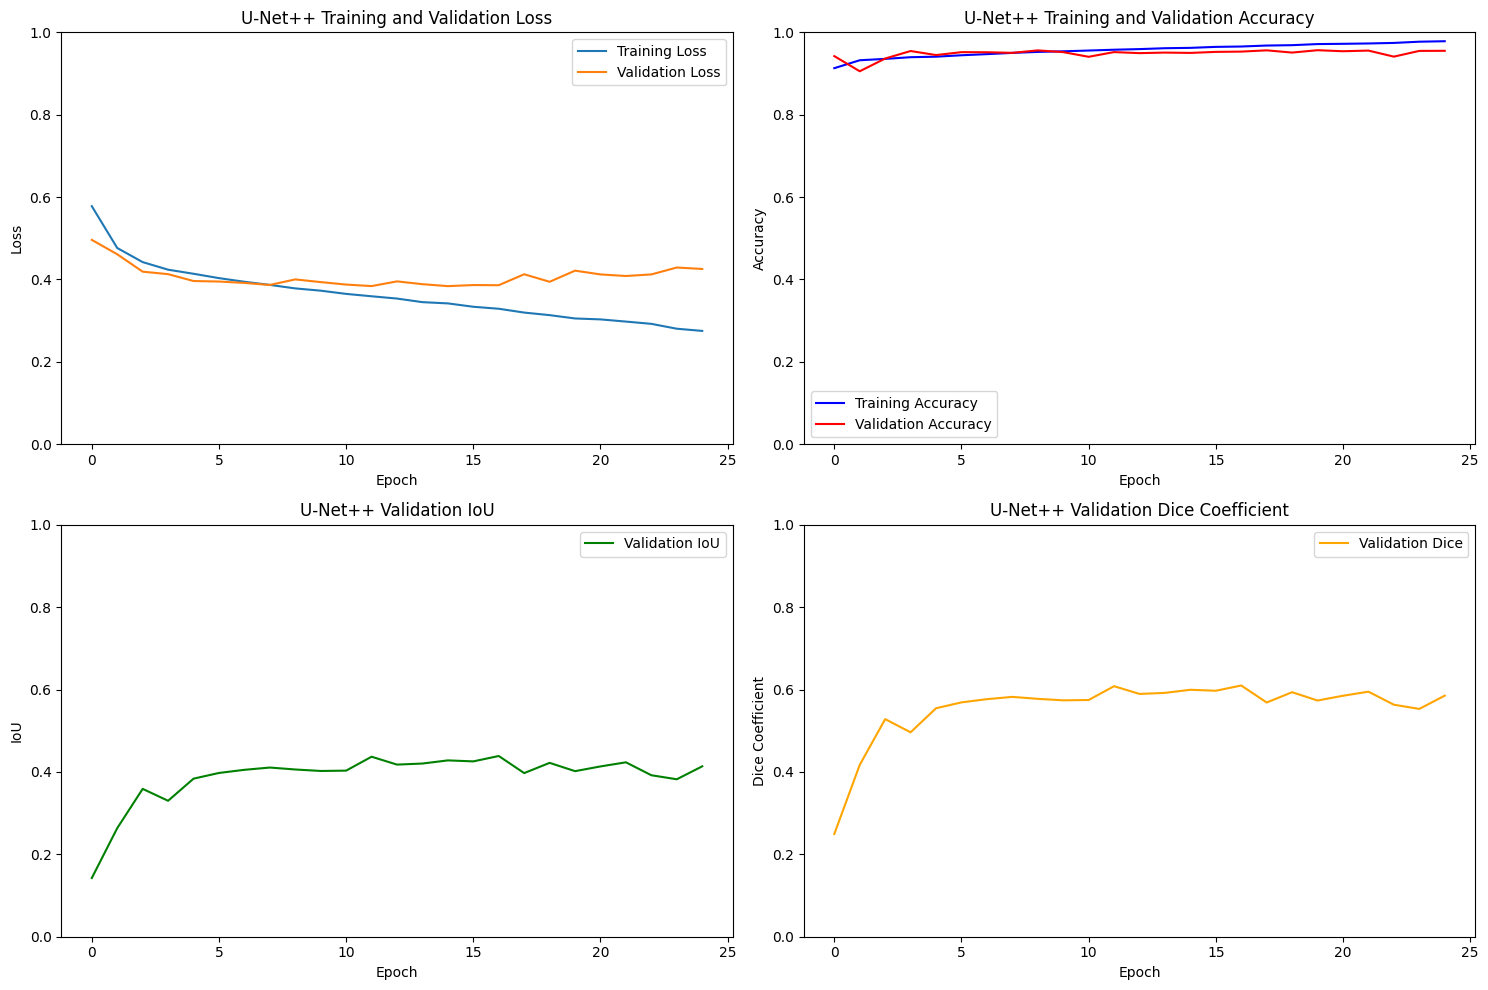

In [7]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_ylim(0, 1)
ax1.legend()
ax1.set_title('U-Net++ Training and Validation Loss')

ax2.plot(train_accs, label='Training Accuracy', color='blue')
ax2.plot(val_accs, label='Validation Accuracy', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.set_title('U-Net++ Training and Validation Accuracy')

ax3.plot(val_ious, label='Validation IoU', color='green')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('IoU')
ax3.set_ylim(0, 1)
ax3.legend()
ax3.set_title('U-Net++ Validation IoU')

ax4.plot(val_dices, label='Validation Dice', color='orange')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Dice Coefficient')
ax4.set_ylim(0, 1)
ax4.legend()
ax4.set_title('U-Net++ Validation Dice Coefficient')

plt.tight_layout()
plt.savefig('unetpp_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## Test Evaluation

Loading best U-Net++ model for test evaluation...

Evaluating U-Net++ on test set...


Val batch: 100%|██████████| 332/332 [00:18<00:00, 17.60it/s]



U-NET++ TEST EVALUATION METRICS
Configuration: Matching SegFormer (lr=2e-4, dropout=0.15, threshold=0.5)
Test set processed with batch_size=1
Loss:            0.390213
IoU:             0.4036
mIoU:            0.6743
Dice Coefficient: 0.5751
Accuracy:        0.9470
Precision:       0.5486
Recall:          0.6042
F1-Score:        0.5751
Confusion matrix (pixel-level):
[[19824013   642228]
 [  511254   780457]]


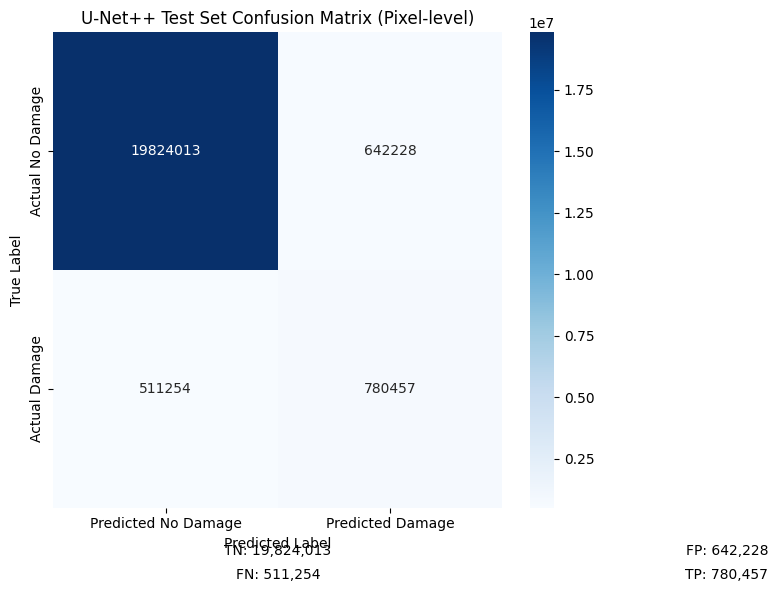

U-Net++ training and evaluation completed!


In [8]:
print("Loading best U-Net++ model for test evaluation...")
model.load_state_dict(torch.load('best_unetpp_earthquake.pth', map_location=device))
model.to(device)

print("\nEvaluating U-Net++ on test set...")
test_metrics = validate(model, test_loader)

print("\n" + "="*50)
print("U-NET++ TEST EVALUATION METRICS")
print("Configuration: Matching SegFormer (lr=2e-4, dropout=0.15, threshold=0.5)")
print("="*50)
print(f"Test set processed with batch_size=1")
print(f"Loss:            {test_metrics['loss']:.6f}")
print(f"IoU:             {test_metrics['iou']:.4f}")
print(f"mIoU:            {test_metrics['miou']:.4f}")
print(f"Dice Coefficient: {test_metrics['dice']:.4f}")
print(f"Accuracy:        {test_metrics['acc']:.4f}")
print(f"Precision:       {test_metrics['precision']:.4f}")
print(f"Recall:          {test_metrics['recall']:.4f}")
print(f"F1-Score:        {test_metrics['f1']:.4f}")
print("Confusion matrix (pixel-level):")
print(test_metrics["confusion"])
print("="*50)

plt.figure(figsize=(8, 6))
cm = test_metrics["confusion"]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No Damage', 'Predicted Damage'],
            yticklabels=['Actual No Damage', 'Actual Damage'])
plt.title('U-Net++ Test Set Confusion Matrix (Pixel-level)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.text(0.5, -0.1, f'TN: {cm[0,0]:,}', ha='center', transform=plt.gca().transAxes)
plt.text(1.5, -0.1, f'FP: {cm[0,1]:,}', ha='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.15, f'FN: {cm[1,0]:,}', ha='center', transform=plt.gca().transAxes)
plt.text(1.5, -0.15, f'TP: {cm[1,1]:,}', ha='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.savefig('unetpp_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("U-Net++ training and evaluation completed!")
